# AIM: see how the combustion properties change at different $P$, $T$ and $[*]$ for a reaction $O_2 + H_2 $
### Physical description of the problem:
`NASA CEA` uses a thermodynamical equilibrium approach in order to find $T$, $P$, $[*]$ ... inside the system.

The thermodynamical equilibrium is based on the 2nd thermodynamic law: $dS_{uni} \geq 0$

In a combustion chamber where $\Delta P \approx 0$ and $\Delta T \approx 0$ we can use the thermodynamic potential: Gibbs free energy $G = H - T S$.

In order to find the thermodynamic equilibrium the Gibbs free energy must be at its minimum $dG\mid_{T,P,m} = 0$.
We can call $g_{mix}$ as the $G$ for unit mass.

$g_{mix}$ can be described with a chemical contribute plus a kinetic one, $g_{mix} = \sum_{i=1}^{N} \ N_i \Big( g_i^0 + R_u T \log{\frac{P_i}{P}} \Big) $.

Imposing $dg_{mix}\mid_{T,P,m} = 0$ we can achieve the equilibrium through $g_i^0$ and $P_i$ (imposing, by default, the conservation of mass on the chemical reaction, $\nu_i$).

The numerical solution of the problem will end up with a research of the partial pressures $P_i$ that allow the equilibrium.

## IMPORTANT VALUES:
* O/F: $\frac{oxidizer}{fuel} = \frac{Ox \ [mol]}{F \ [mol]}$ or $\frac{oxidizer}{fuel} = \frac{Ox \ [kg]}{F \ [kg]}$ 
* molar concentration: $c_i = \frac{n_i}{N_A}$
* mass fraction: $y_i = \frac{\rho_i}{\rho} = \frac{M_i}{M}$
* molar fraction: $x_i = \frac{n_i}{n} = \frac{c_i}{c}$
##### * `NASA CEA` expresses the $\frac{O}{F}$ in $\frac{Ox \ [mass]}{F \ [mass]}$
##### * in this program, `NASA CEA` gives output expressed in molar fraction

# NASA CEA case
##### * in this case, `NASA CEA` works with mass, `wt` (total weight). It is possible to work also with `moles`. 
## setup:
* thermodynamic properties: $T_{H_2}$, $T_{O_2}$, $P_{H_2}$ and $P_{O_2}$ 
* mass/molar properties: 
    * mass: `wt`, total weight of the substance inside the system => # of atoms ($mm_i$ relation)
    * moles: `moles`, # of moles of the substance inside the system => # of atoms
##### * with the # of atoms, easy treating with mass conservation
## output:
* $\frac{O}{F}$ in mass. PAY ATTENTION: `NASA CEA` takes into account the mass given in the ***.inp file
* $H, O, H_2, O_2, OH, O_3, H_2O, H_2O(L)$ 
    * molar fractions by default
    * mass fractions if as input: `massf` 
* $cp$ specific heat at constant pressure

In [1]:
# importing libraries
import os  
import numpy             as np 
import seaborn           as sbn 
import matplotlib.pyplot as plt

## definition of classes
### COMB() class:
*  get_data() 
*  problem_generator()

In [2]:
# determining a class where storing the data 
class COMB:
    '''
    COMBUSTION results
    --- variables:
          thermodynamic:
            P    
            T    
            of   
            m    
            cp   
          mass:
            H    
            H2   
            O    
            O2   
            O3   
            OH   
            H2O  
            H2OL 
    '''
    def __init__(self):
        # COMB initial values are setted to 0
        self.P    = 0.0
        self.T    = 0.0
        self.of   = 0.0
        self.m    = 0.0
        self.cp   = 0.0
        self.H    = 0.0
        self.H2   = 0.0
        self.O    = 0.0
        self.O2   = 0.0
        self.O3   = 0.0
        self.OH   = 0.0
        self.H2O  = 0.0
        self.H2OL = 0.0
    
    def get_data(self,target):
        '''
        Reading data from the result of NASA_CEA simulation
        --- uses the ***.plt file as data source
        '''
        with open(target, 'r') as file: 
            file.readlines(1)
            DATA = file.readlines(1)
            data = np.empty(0)
            # read only the 2nd line 
            for line in DATA:
                # reading each word in the line 
                for value in line.split():
                    data = np.concatenate((data, value), axis=None)
            
        # allocating data
        self.of   = float(data[0])
        self.P    = float(data[1])
        self.T    = float(data[2])
        self.m    = float(data[3])
        self.cp   = float(data[4]) 
        self.H    = float(data[5])
        self.H2   = float(data[6])
        self.O    = float(data[7])
        self.O2   = float(data[8])
        self.O3   = float(data[9])
        self.OH   = float(data[10])
        self.H2O  = float(data[11])
        self.H2OL = float(data[12])
   
    def problem_generation(self,T,P,FUEL,OX,target):
        '''
        This subroutine generates the ***.inp file to be analyzed by NASA_CEA
        The problem is a combustion problem. It is given as input:
            T      -- temperature of each reactant
            P      -- combustion chamber pressure
            FUEL   -- fuel total weight
            OX     -- oxidizer total weight
            target -- file name (used by NASA_CEA)
        '''

        with open(target, 'w') as file: 
            file.write('problem   case=case_01 \n')
            # problem description
            text = '    hp   p,bar=' + str(P) + '\n'# + ',  t,k=' + str(T) + '\n'
            file.write(text)
            
            file.write('react \n')
            # fuel description
            text = '    fuel=H2 wt=' + str(FUEL) + ',  t,k=' + str(T) + '\n'
            file.write(text)
            # oxidazer description
            text = '    oxid=O2 wt=' + str(OX) +   ',  t,k=' + str(T) + '\n'  
            file.write(text)  
            
            file.write('output  transport short trace= 1e-10\n')
            file.write('    plot o/f p t m cp H H2 O O2 O3 OH H2O H2O(L)\n')
            file.write('end \n')  

## definition of functions
* print_list()
* setup_problem()
* plot_fraction()
* mass_mol_conversion()

In [3]:
def print_list(CC):
    '''
    This function gets the data from the COMB() list and stores it into the arrays:
        t    -- temperature array
        p    -- pressure array
        of   -- O/F array
        m    -- molar mass array
        cp   -- CP array
        H    -- H molar/mass fraction array
        H2   -- H2 molar/mass fraction array
        O    -- O molar/mass fraction array
        O2   -- O2 molar/mass fraction array
        O3   -- O3 molar/mass fraction array
        OH   -- OH molar/mass fraction array
        H2O  -- H2O(gas) molar/mass fraction array
        H2OL -- H2O(liquid) molar/mass fraction array

    PAY ATTENTION: it is possible to store molar or mass fractions, this because the rules in the ***.inp file
    '''
    # getting data from object list
    t    = np.zeros(len(CC))
    of   = np.zeros(len(CC))
    p    = np.zeros(len(CC))
    m    = np.zeros(len(CC))
    cp   = np.zeros(len(CC))
    H    = np.zeros(len(CC))
    H2   = np.zeros(len(CC))
    O    = np.zeros(len(CC))
    O2   = np.zeros(len(CC))
    O3   = np.zeros(len(CC))
    OH   = np.zeros(len(CC))
    H2O  = np.zeros(len(CC))
    H2OL = np.zeros(len(CC))

    for ii in range(0,len(CC)):
        # getting system status values
        # getting temperature
        t[ii]    = CC[ii].T
        # getting of
        of[ii]   = CC[ii].of
        # getting pressure
        p[ii]    = CC[ii].P
        # getting average molecular mass
        m[ii]    = CC[ii].m
        # getting cp
        cp[ii]   = CC[ii].cp
        # getting molar/mass fraction of mixture's species
        # getting H 
        H[ii]    = CC[ii].H
        # getting H2
        H2[ii]   = CC[ii].H2
        # getting O
        O[ii]    = CC[ii].O
        # getting O2 
        O2[ii]   = CC[ii].O2
        # getting O3
        O3[ii]   = CC[ii].O3
        # getting OH
        OH[ii]   = CC[ii].OH
        # getting H2O 
        H2O[ii]  = CC[ii].H2O
        # getting H2OL 
        H2OL[ii] = CC[ii].H2OL

    return t, p, of, m, cp, H, H2, O, O2, O3, OH, H2O, H2OL 

def setup_problem(P_vec,T_vec,H2_vec,O2_vec):
    '''
    This subroutine computes the different cases for the [H2 + O2] combustion given:
        P_vec  -- chamber pressure array
        T_vec  -- reactants initial temperature array
        H2_vec -- H2 initial weight array
        O2_vec -- O2 initial weight array
    '''

    # check on input data
    if(len(P_vec)!=len(T_vec) & len(P_vec)!=len(H2_vec) & len(P_vec)!=len(O2_vec)):
        print('The lenght of the input data vectors are not equal: error')

    # initializing combustion's result list
    CC = np.array([COMB() for ii in range(0,len(P_vec))])
    
    # analyzing all cases
    for ii,pressure in enumerate(P_vec):
        temperature = T_vec[ii]
        h2          = H2_vec[ii]
        o2          = O2_vec[ii]
        CC[ii].problem_generation(temperature,pressure,h2,o2,'case_01.inp') 
        os.system('bash ./CEA_case')
        CC[ii].get_data('case_01.plt')

    # getting data from object list
    t, p, of, m, cp, H, H2, O, O2, O3, OH, H2O, H2OL = print_list(CC)

    return t, p, of, m, cp, H, H2, O, O2, O3, OH, H2O, H2OL 

def plot_fraction(of,O,O2,OH,H,H2,H2O,pressure,temperature):
    '''
    This subroutine plots the molar/mass fraction for a set of combustion processes
    PAY ATTENTION at the data assignment in the program 
    '''
    # plotting data
    sbn.set_theme()
    figname = plt.figure()
    axname  = figname.add_axes([0,0,1,1])
    
    try:
        axname.plot(of,O,  'y', label=r'$O$',    linewidth=2)
    except:
        pass

    try:
        axname.plot(of,O2, 'b', label=r'$O_2$',  linewidth=2)
    except:
        pass

    try:
        axname.plot(of,OH, 'r', label=r'$OH$',   linewidth=2)
    except:
        pass

    try:
        axname.plot(of,H,  'm', label=r'$H$',    linewidth=2)
    except:
        pass

    try:
        axname.plot(of,H2, 'c', label=r'$H_2$',  linewidth=2)
    except:
        pass
    
    try:
        axname.plot(of,H2O,'k', label=r'$H_2O$', linewidth=2)
    except:
        pass

    chartBox = axname.get_position()
    axname.set_position([chartBox.x0, chartBox.y0, chartBox.width*0.8, chartBox.height])
    axname.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), shadow=True, ncol=2)

    plt.title(r'$\frac{O}{F} \ vs \  [*], \  P_{CC} = ' + str(pressure) + 'bar, \ T_{in} = ' + str(temperature) +  'K$')
    plt.xlabel(r'$\frac{O}{F} \ [ \frac{kg}{kg} ] $')
    plt.ylabel(r'$x_{products}$')

    plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 
    plt.show()

    def mass_mol_conversion(H2_frac):
        '''
        This function converts in moles number the mass for a H2 + O2 mixture:
        --- 1 g of mass
            1 mol of H weights 1 g => 1 mol of H2 weights  2 g
            1 mol of O weights 8 g => 1 mol of O2 weights 16 g

            input:
                H2_frac = H2 mass fraction

            output:
                molH2 = H2 total weight
                molO2 = O2 total weight
        '''

        H2weight = 2
        O2weight = 16 

        molH2 = H2_frac / H2weight
        molO2 = (1 - H2_frac) / O2weight

        return molH2, molO2 

# Study of properties variation wtr $ T $ and $ P $
### given $[H_2]$ and $[O_2]$, there are computed $x_H$, $x_O$ and $x_{OH}$ in the system at the end of combustion
##### * $x_{***}$ is the molar fraction

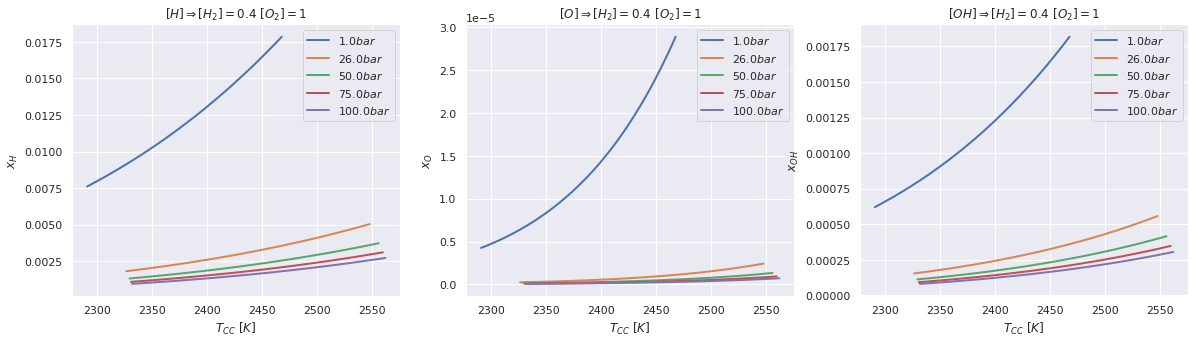

In [4]:
# setting up the interval of study
T  = np.linspace(200,500,50)
P  = np.linspace(1,100,5)

# generation of object list 
CC_P = np.array([COMB() for ii in range(0,len(T))])

# creating the figure 
sbn.set_theme()
fig1, ax      = plt.subplots(nrows=1, ncols=3, figsize=(20,5))
ax1, ax2, ax3 = ax.flatten()

# setting reactants total weight
h2 = 0.4
o2 = 1

for pressure in P:
    for ii,temperature in enumerate(T):
        CC_P[ii].problem_generation(temperature,pressure,h2,o2,'case_01.inp') 
        os.system('bash ./CEA_case')
        CC_P[ii].get_data('case_01.plt')

        # getting data from object list
        t, p, of, m, cp, H, H2, O, O2, O3, OH, H2O, H2OL = print_list(CC_P)

    # plotting data
    ax1.plot(t,H,label=r'$'  + str(round(pressure,0)) + 'bar$',linewidth=2)
    ax2.plot(t,O,label=r'$'  + str(round(pressure,0)) + 'bar$',linewidth=2)
    ax3.plot(t,OH,label=r'$' + str(round(pressure,0)) + 'bar$',linewidth=2)

# axis description
ax1.legend()
ax1.set_title(r'$[H] \Rightarrow [H_2] = ' + str(h2) + ' \ [O_2] = ' + str(o2) + '$')
ax1.set_xlabel(r'$T_{CC} \ [K]$')
ax1.set_ylabel(r'$x_{H}$')

ax2.legend()
ax2.set_title(r'$[O] \Rightarrow [H_2] = ' + str(h2) + ' \ [O_2] = ' + str(o2) + '$')
ax2.set_xlabel(r'$T_{CC} \ [K]$')
ax2.set_ylabel(r'$x_{O}$')

ax3.legend()
ax3.set_title(r'$[OH] \Rightarrow [H_2] = ' + str(h2) + ' \ [O_2] = ' + str(o2) + '$')
ax3.set_xlabel(r'$T_{CC} \ [K]$')
ax3.set_ylabel(r'$x_{OH}$')

plt.show()

# Study of properties variation wtr $P$ and $\frac{O}{F}$
### given $T$, it is computed the change in $x_H$, $x_O$ and $x_{OH}$ of chemical species inside the system
##### * $\frac{O}{F}$ roundoff in the plot
##### * $x_{***}$ is the molar fraction

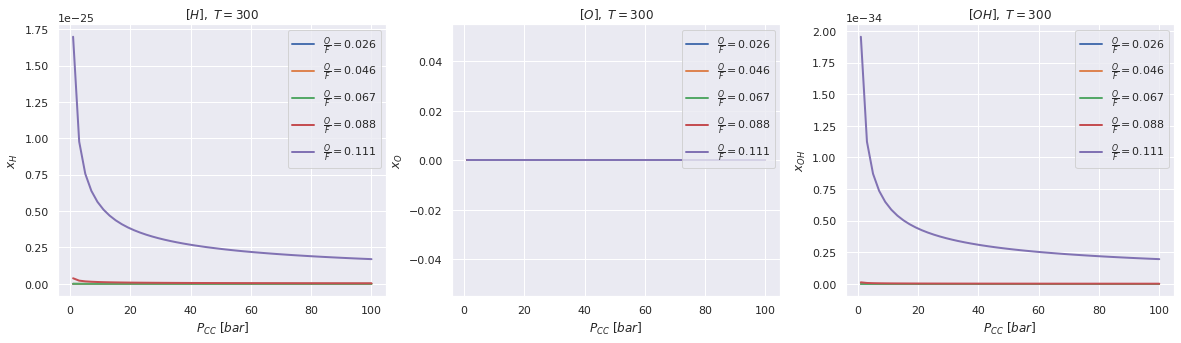

In [7]:
# setting up the interval of study
# reactants total weight
O2_vec = np.linspace(0.025,0.1,5)
H2_vec = 1 - O2_vec
# initial conditions
temperature = 300
P           = np.linspace(1,100,50)

# generation of object list 
CC_P = np.array([COMB() for ii in range(0,len(P))])

# creating the figure 
sbn.set_theme()
fig2, ax = plt.subplots(nrows=1, ncols=3, figsize=(20,5))
ax1, ax2, ax3 = ax.flatten()

for ii,h2 in enumerate(H2_vec):
    o2 = O2_vec[ii]
    for ii,pressure in enumerate(P):
        CC_P[ii].problem_generation(temperature,pressure,h2,o2,'case_01.inp') 
        os.system('bash ./CEA_case')
        CC_P[ii].get_data('case_01.plt')

    # getting data from object list
    t, p, of, m, cp, H, H2, O, O2, O3, OH, H2O, H2OL = print_list(CC_P)

    # plotting data
    ax1.plot(p,H,  label=r'$ \frac{O}{F} = ' + str(round(of[0],ndigits=3)) + ' $',linewidth=2)
    ax2.plot(p,O,  label=r'$ \frac{O}{F} = ' + str(round(of[0],ndigits=3)) + ' $',linewidth=2)
    ax3.plot(p,OH, label=r'$ \frac{O}{F} = ' + str(round(of[0],ndigits=3)) + ' $',linewidth=2)

# axis description
ax1.legend()
ax1.set_title(r'$[H], \ T = ' + str(temperature) + '$')
ax1.set_xlabel(r'$P_{CC} \ [bar] $')
ax1.set_ylabel(r'$x_{H}$')

ax2.legend()
ax2.set_title(r'$[O], \ T = ' + str(temperature) + '$')
ax2.set_xlabel(r'$P_{CC} \ [bar]$')
ax2.set_ylabel(r'$x_{O}$')

ax3.legend()
ax3.set_title(r'$[OH], \ T = ' + str(temperature) + '$')
ax3.set_xlabel(r'$P_{CC} \ [bar]$')
ax3.set_ylabel(r'$x_{OH}$')

plt.show()

# Study of properties variation wtr $[H_2]$ and $[O_2]$
### given $P$ and $T$, it is computed the change in $x_H$, $x_{H2}$, $x_{O}$, $x_{O_2}$, $x_{O_3}$, $x_{OH}$, $x_{H_2 O}$ and $x_{H_2O_{L}}$  inside the system
##### * $x_{***}$ is the molar fraction

<ipython-input-3-348c58ad86be>:145: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])


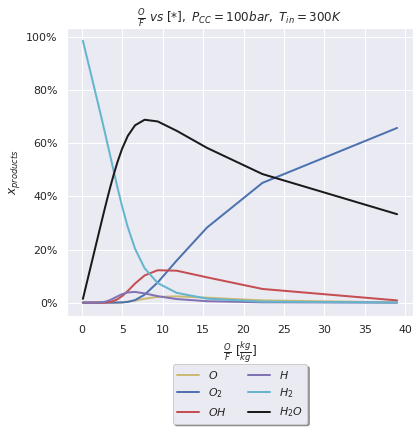

In [6]:
# reactants
O2_vec = np.linspace(0.1,0.975,50)
H2_vec = 1 - O2_vec

# generation of object list 
CC_C = np.array([COMB() for ii in range(0,len(H2_vec))])

for ii,h2 in enumerate(H2_vec):
    temperature = 300
    pressure    = 100
    o2          = O2_vec[ii]
    CC_C[ii].problem_generation(temperature,pressure,h2,o2,'case_01.inp') 
    os.system('bash ./CEA_case')
    CC_C[ii].get_data('case_01.plt')

# getting data from object list
t, p, of, m, cp, H, H2, O, O2, O3, OH, H2O, H2OL = print_list(CC_C)

# plotting data
plot_fraction(of,O,O2,OH,H,H2,H2O,pressure,temperature)

plt.show()